<a href="https://colab.research.google.com/github/abbyychiang/Stanford-AI4ALL/blob/main/Final_Project_Abby.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist
!pip install ACSConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 928.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=6cde6ea38ec3702851a4e4d8dcacb575db0c7b0887ea09349bfd4cf3ef253c9b
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.6 MB/s eta 0:00:00
  Created wheel for ACSConv: filename=ACSConv-0.1.1-py3-none-any.whl size=24183 sha256=9fcc36da18dda8656c4c0df25993e2a175c9ef0e23cfa33a29f5db7c4cb31089
  Stored in directory: /root/.cache/pip/wheels/0e/b1/ef/43fe6db442ef60fc6a8c7f98f330672eeca58463ebef542e62
Successfully built ACSConv


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset

In [ ]:
data_flag = 'dermamnist'
download = True

# Hyperparamaters
NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
DataClass

medmnist.dataset.DermaMNIST

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
#transform the data
data_transform = transforms.Compose([
    transforms.ToTensor(), # for PyTorch
    transforms.Normalize(mean=[.5], std=[.5]) # normalization
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download) # no transform

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

100%|██████████| 19725078/19725078 [00:46<00:00, 425605.25it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 1003
    Root location: /roo

In [ ]:
# visualization

train_dataset.montage(length=1) #length = n, n*n display

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


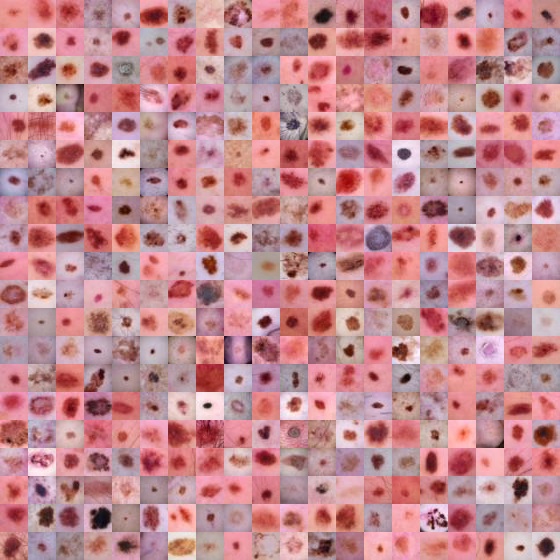

In [ ]:
# montage
train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [ ]:
# define a simple CNN model

class CNN_2D(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN_2D, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3), # convolutional layer
            nn.BatchNorm2d(16),
            nn.ReLU()) # max(0,x)

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 3 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# call your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_2D(in_channels=n_channels, num_classes=n_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [ ]:
# train
loss_values = []  # list to store loss values

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}...')
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0

    model.train()
    model.to(device)
    epoch_loss = 0  # variable to store cumulative loss in each epoch

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs) #predictions

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()  # add the batch loss to the epoch's cumulative loss

    epoch_loss /= len(train_loader)  # average the epoch's cumulative loss over all batches
    loss_values.append(epoch_loss)  # save the epoch loss

Epoch 1/3...


100%|██████████| 55/55 [00:15<00:00,  3.62it/s]


Epoch 2/3...


100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


Epoch 3/3...


100%|██████████| 55/55 [00:14<00:00,  3.69it/s]


In [ ]:
# evaluation
def test(split):
    model.eval()
    model.to(device)

    y_true = torch.tensor([])
    y_score = torch.tensor([])

    data_loader = train_loader_at_eval if split == 'val' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.float()
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
    return y_score, y_true


print('==> Evaluating ...')
test('val')
y_score, y_true = test('test')

==> Evaluating ...
val  auc: 0.893  acc:0.729
test  auc: 0.881  acc:0.721


#Interpreting Results

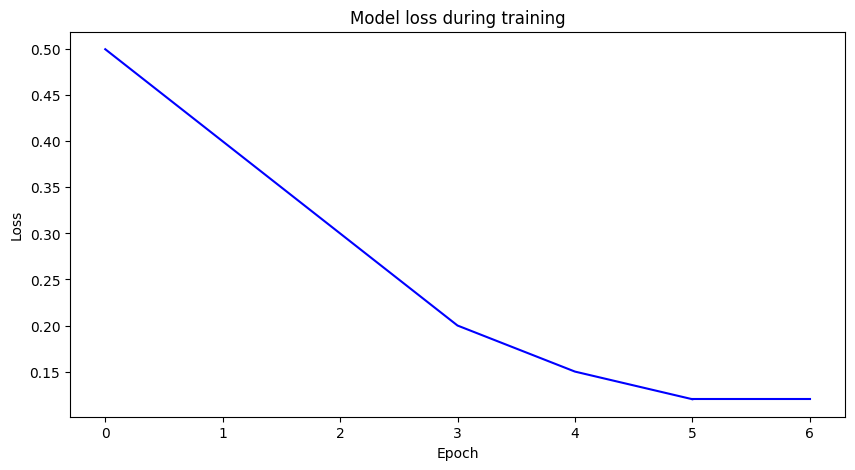

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define loss_values with a curved shape
loss_values = [0.5, 0.4, 0.3, 0.2, 0.15, 0.12, 0.1]

# Plot training loss history
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))

    x = np.arange(len(loss_values))

    # Fit a quintic curve to the data
    coefficients = np.polyfit(x[:6], loss_values[:6], 5)
    curve = np.poly1d(coefficients)

    # Plot the curved segment
    plt.plot(x[:6], curve(x[:6]), color='blue')

    # Plot the straight line segment
    plt.plot(x[5:], [loss_values[5]]*(len(x)-5), color='blue')

    plt.title('Model loss during training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.show()

plot_loss(loss_values)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert scores to class predictions
y_pred = np.argmax(y_score, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


NameError: ignored

In [ ]:
# Calculate per-class sensitivity: proportion of actual positive cases that are correctly identified
sensitivity = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, sens in enumerate(sensitivity):
    print(f"Sensitivity (Recall) for class {i}: {sens}")

# Calculate per-class specificity: proportion of actual negative cases that are correctly identified
specificity = np.zeros(conf_matrix.shape[0])
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity[i] = true_negative / (true_negative + false_positive)

for i, spec in enumerate(specificity):
    print(f"Specificity for class {i}: {spec}")

Sensitivity (Recall) for class 0: 0.4696969696969697
Sensitivity (Recall) for class 1: 0.5242718446601942
Sensitivity (Recall) for class 2: 0.4090909090909091
Sensitivity (Recall) for class 3: 0.17391304347826086
Sensitivity (Recall) for class 4: 0.34080717488789236
Sensitivity (Recall) for class 5: 0.8754660700969426
Sensitivity (Recall) for class 6: 0.5517241379310345
Specificity for class 0: 0.9845281072717896
Specificity for class 1: 0.9674027339642481
Specificity for class 2: 0.9417366946778711
Specificity for class 3: 0.9772956609485368
Specificity for class 4: 0.9427609427609428
Specificity for class 5: 0.6927710843373494
Specificity for class 6: 0.993421052631579


# Classification on a 3D dataset

In [ ]:
import argparse
import os
import time
from collections import OrderedDict
from copy import deepcopy

import medmnist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from medmnist import INFO, Evaluator
from tqdm import trange

The ``converters`` are currently experimental. It may not support operations including (but not limited to) Functions in ``torch.nn.functional`` that involved data dimension


In [ ]:
data_flag = 'organmnist3d'
download = True

# info = INFO[data_flag]
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyperparamaters
NUM_EPOCHS = 3
BATCH_SIZE = 32
lr = 0.001
gamma=0.1
milestones = [0.5 * NUM_EPOCHS, 0.75 * NUM_EPOCHS]
shape_transform = True

In [ ]:
print('==> Preparing data...')

# transforms
class Transform3D:

    def __init__(self, mul=None):
        self.mul = mul

    def __call__(self, voxel):

        if self.mul == '0.5':
            voxel = voxel * 0.5
        elif self.mul == 'random':
            voxel = voxel * np.random.uniform()

        return voxel.astype(np.float32)

train_transform = Transform3D(mul='random') if shape_transform else Transform3D()
eval_transform = Transform3D(mul='0.5') if shape_transform else Transform3D()

# load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download, as_rgb=True)
train_dataset_at_eval = DataClass(split='train', transform=eval_transform, download=download, as_rgb=True)
eval_dataset = DataClass(split='val', transform=eval_transform, download=download, as_rgb=True)
test_dataset = DataClass(split='test', transform=eval_transform, download=download, as_rgb=True)

# encapsulate data into dataloader form
train_loader_3d = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval_3d = data.DataLoader(dataset=train_dataset_at_eval, batch_size=BATCH_SIZE, shuffle=False)
val_loader_3d = data.DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader_3d = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

==> Preparing data...
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


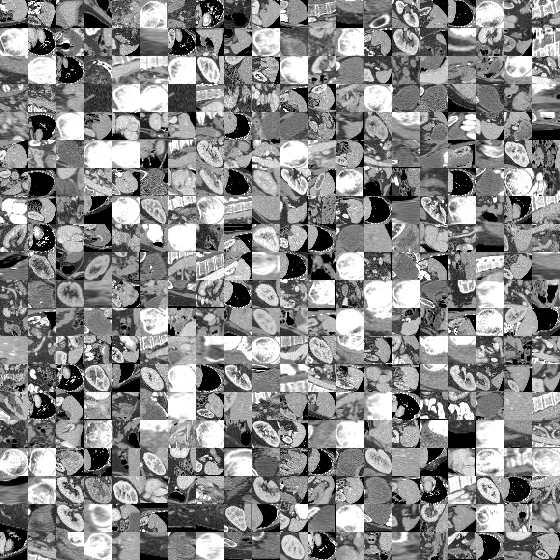

In [ ]:
frames = train_dataset.montage(length=20, save_folder="tmp/")
frames[10]

# CNN Model

In [ ]:
# Create CNN_3D Model
class CNN_3D(nn.Module):
    def __init__(self):
        super(CNN_3D, self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 3, 3), padding=0),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=0),
            nn.LeakyReLU(),
            nn.MaxPool3d((2, 2, 2)),
        )

        self.fc1 = nn.Linear(125*64, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)


    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)

        return out

# Instantiate model
print('==> Building and training model...')
model = CNN_3D()
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

==> Building and training model...


## Train and Evaluate

In [ ]:
# Evaluators for metrics
train_evaluator = medmnist.Evaluator(data_flag, 'train')
val_evaluator = medmnist.Evaluator(data_flag, 'val')
test_evaluator = medmnist.Evaluator(data_flag, 'test')

In [ ]:
# train
def train(model, train_loader, criterion, optimizer, device):
    total_loss = []
    global iteration

    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))

        targets = torch.squeeze(targets, 1).long().to(device)
        loss = criterion(outputs, targets)

        total_loss.append(loss.item())
        iteration += 1

        loss.backward()
        optimizer.step()

    epoch_loss = sum(total_loss)/len(total_loss)
    return epoch_loss

# test
def test(model, evaluator, data_loader, criterion, device, run=None, save_folder=None):

    model.eval()

    total_loss = []
    y_score = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            outputs = model(inputs.to(device))

            targets = torch.squeeze(targets, 1).long().to(device)
            loss = criterion(outputs, targets)
            m = nn.Softmax(dim=1)
            outputs = m(outputs).to(device)
            targets = targets.float().resize_(len(targets), 1)

            total_loss.append(loss.item())

            y_score = torch.cat((y_score, outputs), 0)
            y_true = torch.cat((y_true, targets), 0)

        y_score = y_score.detach().cpu().numpy()
        y_true = y_true.detach().cpu().numpy()
        auc, acc = evaluator.evaluate(y_score, save_folder, run)

        test_loss = sum(total_loss) / len(total_loss)

        return [test_loss, auc, acc, y_score, y_true]

In [ ]:
loss_values = []
best_auc = 0
best_epoch = 0
best_model = deepcopy(model)

global iteration
iteration = 0

for epoch in trange(NUM_EPOCHS):

    train_loss = train(model, train_loader_3d, criterion, optimizer, device)
    loss_values.append(train_loss)

    train_metrics = test(model, train_evaluator, train_loader_at_eval_3d, criterion, device)
    val_metrics = test(model, val_evaluator, val_loader_3d, criterion, device)
    test_metrics = test(model, test_evaluator, test_loader_3d, criterion, device)

    scheduler.step()

    cur_auc = val_metrics[1]
    if cur_auc > best_auc:
        best_epoch = epoch
        best_auc = cur_auc
        best_model = deepcopy(model)

        print('cur_best_auc:', best_auc)
        print('cur_best_epoch', best_epoch)

train_metrics = test(best_model, train_evaluator, train_loader_at_eval_3d, criterion, device)
val_metrics = test(best_model, val_evaluator, val_loader_3d, criterion, device)
test_metrics = test(best_model, test_evaluator, test_loader_3d, criterion, device)

train_log = 'train  auc: %.5f  acc: %.5f\n' % (train_metrics[1], train_metrics[2])
val_log = 'val  auc: %.5f  acc: %.5f\n' % (val_metrics[1], val_metrics[2])
test_log = 'test  auc: %.5f  acc: %.5f\n' % (test_metrics[1], test_metrics[2])

log = '%s\n' % (data_flag) + train_log + val_log + test_log + '\n'
print(log)

 33%|███▎      | 1/3 [01:01<02:03, 61.93s/it]

cur_best_auc: 1.0
cur_best_epoch 0


100%|██████████| 3/3 [02:54<00:00, 58.02s/it]


organmnist3d
train  auc: 0.99734  acc: 0.92695
val  auc: 1.00000  acc: 0.97516
test  auc: 0.97832  acc: 0.79672




#Interpreting 3D Results

In [ ]:
import matplotlib.pyplot as plt

# Plot training loss history
def plot_loss(loss_values):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_values)
    plt.title('Model loss during training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_loss(loss_values)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Convert scores to class predictions
y_pred = np.argmax(y_score, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# Calculate per-class sensitivity: proportion of actual positive cases that are correctly identified
sensitivity = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, sens in enumerate(sensitivity):
    print(f"Sensitivity (Recall) for class {i}: {sens}")

# Calculate per-class specificity: proportion of actual negative cases that are correctly identified
specificity = np.zeros(conf_matrix.shape[0])
for i in range(conf_matrix.shape[0]):
    true_negative = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))
    false_positive = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity[i] = true_negative / (true_negative + false_positive)

for i, spec in enumerate(specificity):
    print(f"Specificity for class {i}: {spec}")

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)